# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## Подготовка данных

### Установка библиотек и настройка окружения

In [169]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
import shap
from sklearn.linear_model import LinearRegression
from IPython.display import display

from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
import time
import lightgbm as lgb
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier

import scipy
import scipy.stats as stats
from scipy.stats import poisson

import phik
from phik import resources, report

warnings.filterwarnings('ignore')

In [91]:
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.2f}'.format

### Инициализация полезных функций

In [92]:
def get_stratified_sample(data, stratify_column='column_for_stratification', sample_size=100000):
    """
    Возвращает случайные sample_size строк из датафрейма data, сохраняя пропорциональное представление значений в stratify_column.
    
    Parameters:
    data (pd.DataFrame): Исходный датафрейм.
    stratify_column (str): Название колонки, по которой нужно стратифицировать выборку.
    sample_size (int): Размер выборки.
    
    Returns:
    pd.DataFrame: Датафрейм, содержащий случайную стратифицированную выборку указанного размера.
    """
    # Разделение данных на "обучающий" набор (который будет отброшен) и "тестовый" набор, который является нужной выборкой
    _, data_sample = train_test_split(data, test_size=sample_size, stratify=data[stratify_column], random_state=42)
    
    return data_sample

In [93]:
class DatasetSizeTracker:
    def __init__(self):
        self.initial_size = None
        self.previous_size = None

    def track(self, data):
        # Если исходный размер не был установлен, запоминаем его и текущий размер как первоначальный
        if self.initial_size is None:
            self.initial_size = len(data)
            self.previous_size = len(data)
            loss_from_initial = 0
            loss_from_previous = 0
            loss_percent_overoll = 0
        else:
            # Считаем, сколько строк потеряно относительно исходного размера и с прошлого вызова
            current_size = len(data)
            loss_from_initial = self.initial_size - current_size
            loss_from_previous = self.previous_size - current_size
            loss_percent_overoll = ((self.initial_size - current_size)/self.initial_size)*100
            # Обновляем предыдущий размер для следующего вызова
            self.previous_size = current_size
        
        return {"Потери от исходного размера": loss_from_initial, "Потери с предыдущего раза": loss_from_previous,
                'Общие потери в процентах' : loss_percent_overoll}

# Создание экземпляра класса для трекинга размера датасета
tracker = DatasetSizeTracker()

In [94]:
# функция информации по таблице
def dataframe_summary(df, string):
    # Вывод общей информации
    print("Общая информация по таблице:", string)
    df.info()

    # Вывод статистического описания
    print("\n Статистическое описание:")
    display(df.describe().transpose())

    # Вывод случайных примеров
    print("\nСлучайные примеры:")
    display(df.sample(5))

    # Вывод количества строк и столбцов
    print("\nКоличество строк и столбцов:", df.shape)
    
    # Вывод количества явных дубликатов
    print("\nКоличество явных дубликатов:", df.duplicated().sum())
    print('')

In [95]:
# функция поиска пропусков
def analyze_missing_values(df, string):
        total = df.isnull().sum().sort_values(ascending=False)
        percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        missing_data = missing_data.query('Total > 0')

        # Вывод информации о пропусках
        print(f"Пропуски в датафрейме {string}:\n{missing_data}\n")

        # Создание и отображение тепловой карты
        plt.figure(figsize=(12, 8))
        sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
        plt.title(f"Heatmap пропусков для {string}")
        plt.show()

In [96]:
# Функция для преобразования названий в змеиный регистр (snake_case) 
def to_snake_case(name): 
    s1 = name[0].lower() 
    for c in name[1:]: 
        if c.isupper(): 
            s1 += '_' 
            s1 += c.lower() 
        else: 
            s1 += c 
    return s1 
 

In [97]:
def fill_missing_values_by_brand_and_model(data, column_name):
    """
    Заполняет пропуски в указанной колонке на основе самого частого значения,
    характерного для сгруппированных данных по 'brand' и 'model'.
    
    Parameters:
    data (pd.DataFrame): Исходный датафрейм.
    column_name (str): Название колонки, в которой нужно заполнить пропуски.
    
    Returns:
    pd.DataFrame: Датафрейм с заполненными пропусками в указанной колонке.
    """
    # Считаем самое частое значение для каждой группы 'brand' и 'model'
    most_frequent_values = data.groupby(['brand', 'model'])[column_name].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Функция для заполнения пропуска
    def fill_value(row):
        if pd.isnull(row[column_name]):
            return most_frequent_values.get((row['brand'], row['model']), row[column_name])
        else:
            return row[column_name]
    
    # Заполнение пропусков
    data[column_name] = data.apply(fill_value, axis=1)
    
    return data

### Обзор данных, работа с дубликатами, пропусками и выбросами

План работы:
1) Анализ описательной статитстики по данным;
2) Очистка явных дубликатов;
3) Обработка пропусков;
4) Обработка выбросов;
5) Анализ визуальной статистики.

#### Обзор данных

In [98]:
data = pd.read_csv('autos.csv')

# Создадим отдельный датасет, который мы оставим в исходном состоянии. 
# Все необходимые преобразования
# data_model = data.copy()

In [99]:
# Для использования функции, укажите DataFrame, колонку для стратификации и желаемый размер выборки:
# data = get_stratified_sample(data, 'Brand', 150000)

In [100]:
dataframe_summary(data, 'Автомобили (data)')

Общая информация по таблице: Автомобили (data)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           35

,count,mean,std,min,25%,50%,75%,max
Price,"354,369.00","4,416.66","4,514.16",0.00,"1,050.00","2,700.00","6,400.00","20,000.00"
RegistrationYear,"354,369.00","2,004.23",90.23,"1,000.00","1,999.00","2,003.00","2,008.00","9,999.00"
Power,"354,369.00",110.09,189.85,0.00,69.00,105.00,143.00,"20,000.00"
Kilometer,"354,369.00","128,211.17","37,905.34","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
RegistrationMonth,"354,369.00",5.71,3.73,0.00,3.00,6.00,9.00,12.00
NumberOfPictures,"354,369.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
PostalCode,"354,369.00","50,508.69","25,783.10","1,067.00","30,165.00","49,413.00","71,083.00","99,998.00"



Случайные примеры:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
148127,2016-04-01 20:39:17,1550,NaN,2017,manual,0,NaN,150000,0,petrol,bmw,no,2016-04-01 00:00:00,0,24103,2016-04-05 17:26:57
129118,2016-03-12 02:57:36,2900,wagon,2001,manual,150,NaN,150000,0,gasoline,bmw,no,2016-03-12 00:00:00,0,88045,2016-04-05 20:19:21
349590,2016-04-01 14:53:46,475,sedan,1996,manual,75,other,150000,6,petrol,fiat,yes,2016-04-01 00:00:00,0,53359,2016-04-07 12:46:22
84685,2016-03-07 15:57:53,1350,sedan,2000,manual,60,a_klasse,150000,3,gasoline,mercedes_benz,no,2016-03-07 00:00:00,0,73230,2016-03-08 12:47:02
318765,2016-03-16 15:46:58,4950,sedan,2009,manual,80,golf,150000,8,petrol,volkswagen,no,2016-03-16 00:00:00,0,93192,2016-03-19 12:47:39



Количество строк и столбцов: (354369, 16)

Количество явных дубликатов: 4



In [101]:
tracker = DatasetSizeTracker()

tracker.track(data)  # Посмотреть, сколько строк потеряно с исходного момента и с последнего вызова

{'Потери от исходного размера': 0,
 'Потери с предыдущего раза': 0,
 'Общие потери в процентах': 0}

Изменим названия переменных, избавимся от дубликатов

In [102]:
data.columns = [to_snake_case(name) for name in data.columns] 
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [103]:
# удалим явные дубликаты
data.drop_duplicates(inplace=True)

В данных есть объявления с ценой равной 0. Тк это целевой признак - менять нельзя, но лучше удалить строки с такой ценой.

In [104]:
print('Сколько людей готовы "подарить" автомобиль:',len(data.loc[data['price'] == 0]))
data = data.loc[data['price'] != 0]
print('Сколько людей готовы "подарить" автомобиль теперь:',len(data.loc[data['price'] == 0]))

Сколько людей готовы "подарить" автомобиль: 10772
Сколько людей готовы "подарить" автомобиль теперь: 0


In [105]:
tracker.track(data) 

{'Потери от исходного размера': 10776,
 'Потери с предыдущего раза': 10776,
 'Общие потери в процентах': 3.0408980469510594}

Пропуски в датафрейме data:
              Total  Percent
repaired      65866    19.17
vehicle_type  33750     9.82
fuel_type     29459     8.57
model         17521     5.10
gearbox       17355     5.05



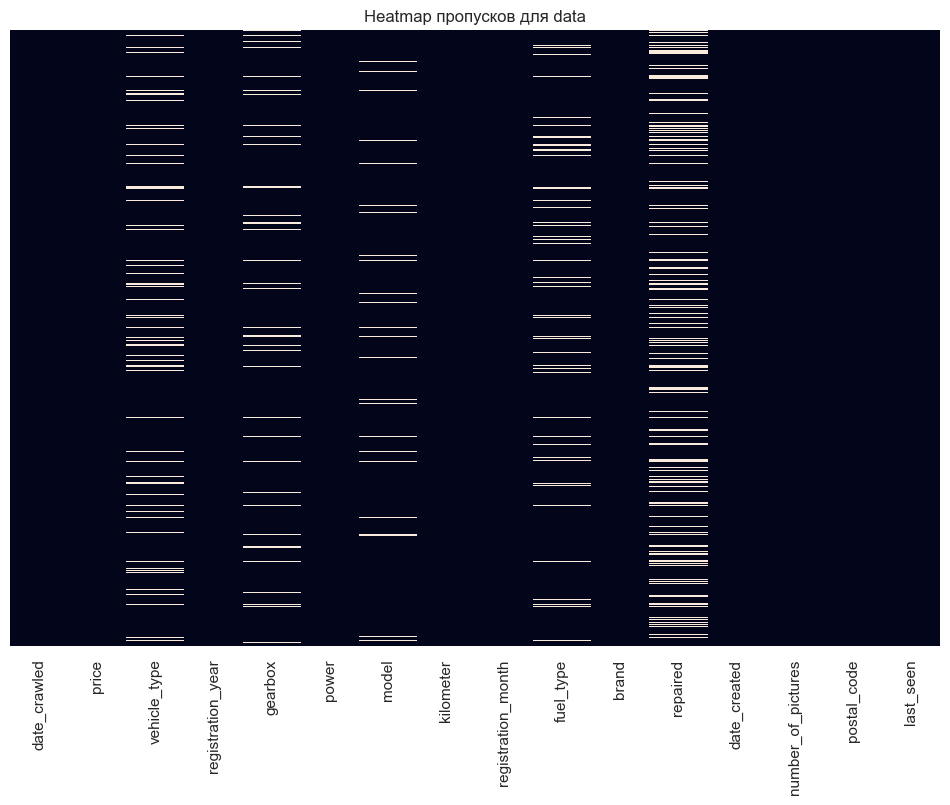

In [106]:
analyze_missing_values(data, 'data')

Избавимся от явных дубликатов, возможно, после обработки датасета и удаления ненужных переменных дубликатов станет больше.

In [107]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 
                  'number_of_pictures', 'postal_code', 'last_seen'], axis =1) 

In [108]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [109]:
display(data[['brand', 'model','vehicle_type', 'fuel_type', 'gearbox', 'power' ,'repaired','price']].sample(10))

,brand,model,vehicle_type,fuel_type,gearbox,power,repaired,price
19793,opel,omega,sedan,petrol,auto,144,NaN,1450
145870,volkswagen,golf,small,petrol,manual,90,no,400
83293,bmw,3er,wagon,petrol,manual,170,NaN,1500
315522,fiat,other,small,gasoline,manual,90,yes,2650
352572,ford,fiesta,small,NaN,manual,60,NaN,350
93975,peugeot,2_reihe,small,petrol,manual,109,no,1800
256183,volkswagen,transporter,bus,gasoline,auto,102,no,8990
8531,bmw,z_reihe,convertible,petrol,manual,118,no,8999
245777,audi,80,wagon,petrol,manual,115,NaN,400
101153,jaguar,other,sedan,petrol,auto,284,no,9950


#### Работа с пропусками

##### Пропуски в `model`

Пропуски в `model`, на мой взгляд, критичны. Фактор модели может играть значительную роль в определении цены машины. Восполнить пропуски здесь никак, заглушка тоже может в данном случае не подойти или нарушить связи. 

In [110]:
data = data.loc[~data['model'].isna()]
tracker.track(data) 

{'Потери от исходного размера': 28297,
 'Потери с предыдущего раза': 17521,
 'Общие потери в процентах': 7.985179290513561}

##### Пропуски в `repaired`

Пропусков в repaired довольно много, порядка 20% от изначального размера данных.\
Фактор довольно важный, при написании объявления обязательно указывать, если машина ремонтировалась. Возможно, значения в этом столбце пропущены, если машина не чинилась и продавцы оставляли незаполненным этот пропуск. \
Если качество модели будет неудовлетворительным, можно попробовать применить заглушку.


In [111]:
data.repaired.value_counts()

repaired
no     235821
yes     31958
Name: count, dtype: int64

In [112]:
data.repaired.fillna('no', inplace=True)

Пропуски в датафрейме data:
              Total  Percent
vehicle_type  28166     8.64
fuel_type     23551     7.22
gearbox       14270     4.38



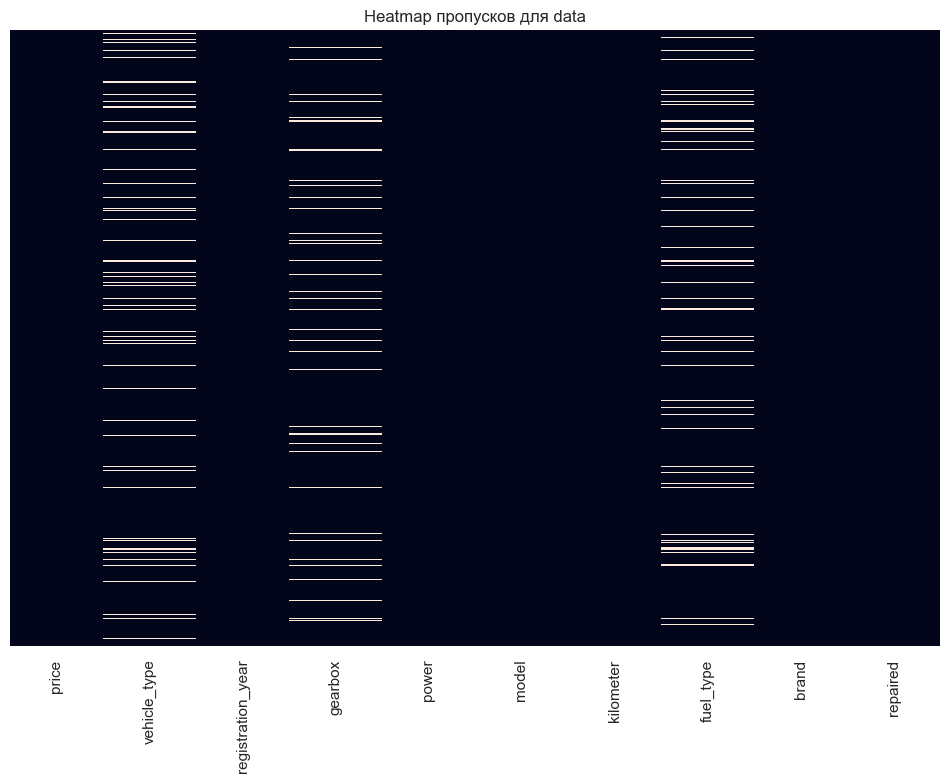

In [113]:
analyze_missing_values(data, 'data')

Остались пропуски в `vehicle_type`,  `fuel_type` и `gearbox` - их заполним на основе данных из `model` и `brand`. 

In [114]:
print(data['vehicle_type'].value_counts())
print(data['fuel_type'].value_counts())
print(data['gearbox'].value_counts())

vehicle_type
sedan          86339
small          74907
wagon          61703
bus            27427
convertible    19038
coupe          14774
suv            11067
other           2651
Name: count, dtype: int64
fuel_type
petrol      202251
gasoline     94503
lpg           4845
cng            534
hybrid         204
other          119
electric        65
Name: count, dtype: int64
gearbox
manual    249988
auto       61814
Name: count, dtype: int64


In [115]:
# используем функцию для заполнения пропусков на основе сгрупиированных данных по brand и model
missing_list = ['vehicle_type', 'fuel_type', 'gearbox']
for i in missing_list:
    data = fill_missing_values_by_brand_and_model(data, i)


In [116]:
print(data['vehicle_type'].value_counts())
print(data['fuel_type'].value_counts())
print(data['gearbox'].value_counts())

vehicle_type
sedan          97918
small          83363
wagon          64900
bus            30942
convertible    19283
coupe          15323
suv            11669
other           2674
Name: count, dtype: int64
fuel_type
petrol      221317
gasoline     98988
lpg           4845
cng            534
hybrid         204
other          119
electric        65
Name: count, dtype: int64
gearbox
manual    262435
auto       63637
Name: count, dtype: int64


#### Обработка аномальных значений

In [117]:
data.describe()

,price,registration_year,power,kilometer
count,"326,072.00","326,072.00","326,072.00","326,072.00"
mean,"4,623.01","2,003.95",111.98,"128,565.73"
std,"4,530.62",66.76,182.97,"37,010.32"
min,1.00,"1,000.00",0.00,"5,000.00"
25%,"1,200.00","1,999.00",71.00,"125,000.00"
50%,"2,950.00","2,003.00",105.00,"150,000.00"
75%,"6,649.00","2,008.00",143.00,"150,000.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00"


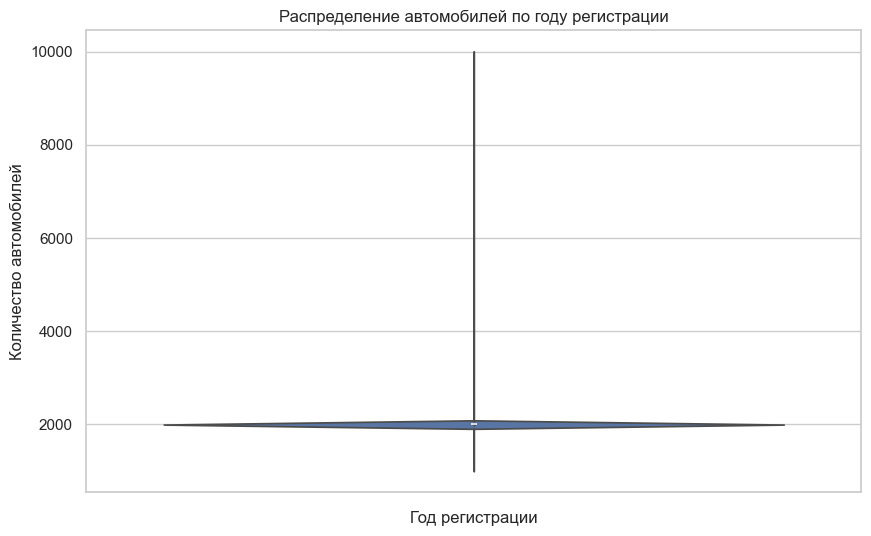

In [118]:
# Установка стиля для графиков
sns.set(style="whitegrid")

# Создание графика распределения значений по годам
plt.figure(figsize=(10, 6))  # Установка размера фигуры
sns.violinplot(data['registration_year'])

plt.title('Распределение автомобилей по году регистрации')  # Заголовок графика
plt.xlabel('Год регистрации')  # Подпись оси X
plt.ylabel('Количество автомобилей')  # Подпись оси Y
plt.xticks(rotation=45)  # Поворот меток на оси X для лучшего отображения

plt.show() 

В данном столбце много выбросов, обработаем выбивающиеся значения. \
Границы отбора данных на изменение предлагаю определить такие:
 * Верхний потолок - 2024 год (машины из 2025года+ пока не производят, к сожалению не придумали)
 * Нижний потолок - машины старше 1980 года. Машин с более поздним годом выпуска совсем немного. 

In [119]:
print(f"Строки с годом регистрации до 1980 или после 2024 составляют {(len(data[(data['registration_year'] < 1980) |  (data['registration_year'] > 2024)]) / len(data)) * 100:.2f}% от всего датасета.")

Строки с годом регистрации до 1980 или после 2024 составляют 0.76% от всего датасета.


In [120]:
tracker.track(data) 

{'Потери от исходного размера': 28297,
 'Потери с предыдущего раза': 0,
 'Общие потери в процентах': 7.985179290513561}

In [121]:
data = data[(data['registration_year'] >= 1985) & (data['registration_year'] <= 2024)]

In [122]:
tracker.track(data) 

{'Потери от исходного размера': 32323,
 'Потери с предыдущего раза': 4026,
 'Общие потери в процентах': 9.121283182219663}

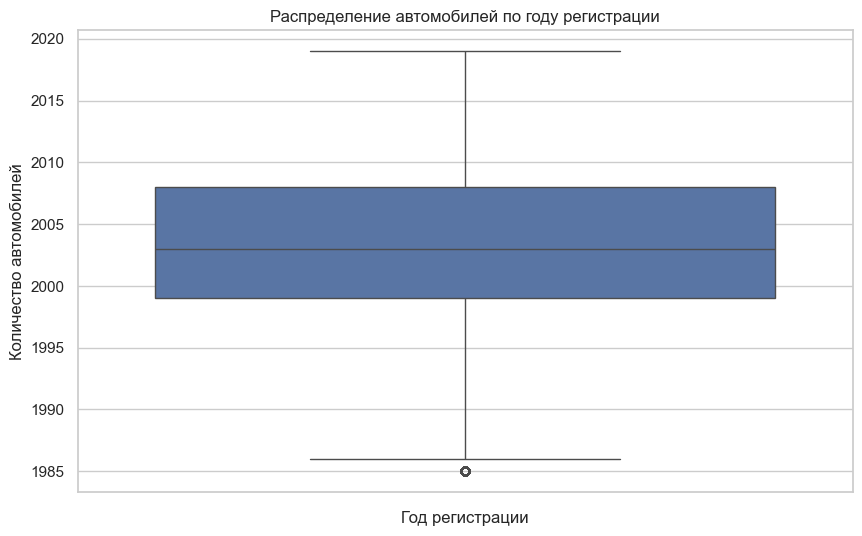

In [123]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data['registration_year'])
plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('Год регистрации') 
plt.ylabel('Количество автомобилей') 
plt.xticks(rotation=45)
plt.show() 

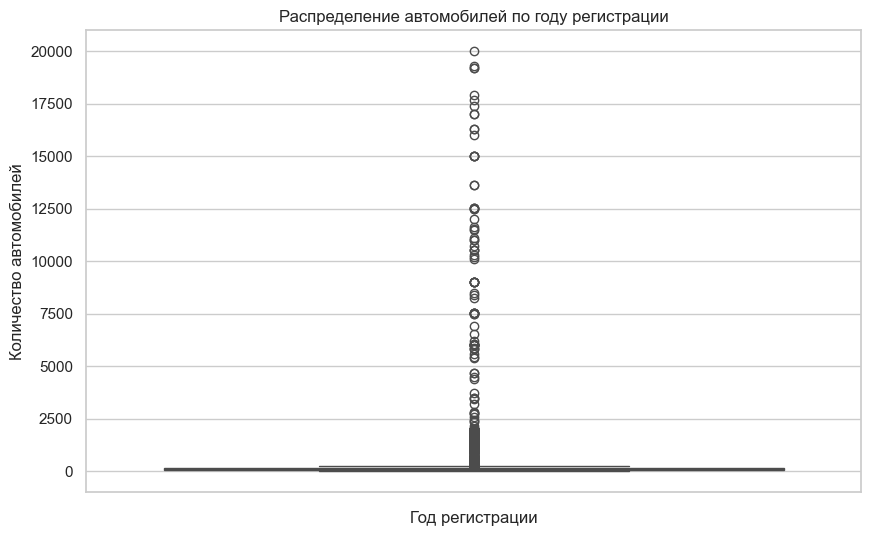

In [124]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data['power'])
plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('Год регистрации') 
plt.ylabel('Количество автомобилей') 
plt.xticks(rotation=45)
plt.show() 

In [125]:
print(f"Строки с слишком большой или малой мощностью составляют {(len(data[(data['power'] < 45) |   (data['power'] > 450)]) / len(data)) * 100:.2f}% от всего датасета.")

Строки с слишком большой или малой мощностью составляют 10.11% от всего датасета.


In [126]:
data_grp = data.groupby(['brand', 'model', 'vehicle_type'])['power'].apply(lambda x: x.median())

In [127]:
def replace_outliers(data, column_name):
    # Считаем самое частое значение для каждой группы 'brand' и 'model'
    most_frequent_values = data.groupby(['brand', 'model', 'vehicle_type'])[column_name].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Функция для заполнения пропуска
    def fill_value(row):
        if row['power'] < 45 or row['power'] > 450:
            return most_frequent_values.get((row['brand'], row['model'], row['vehicle_type']), row[column_name])
        else:
            return row[column_name]
    
    # Заполнение пропусков
    data[column_name] = data.apply(fill_value, axis=1)

    return data

In [128]:
replace_outliers(data, 'power')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,75,golf,150000,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
9,999,small,1998,manual,101,golf,150000,petrol,volkswagen,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes


In [129]:
data = data[(data['power'] <= 450) & (data['power'] >= 45)]

tracker.track(data) 

{'Потери от исходного размера': 35164,
 'Потери с предыдущего раза': 2841,
 'Общие потери в процентах': 9.922989877782763}

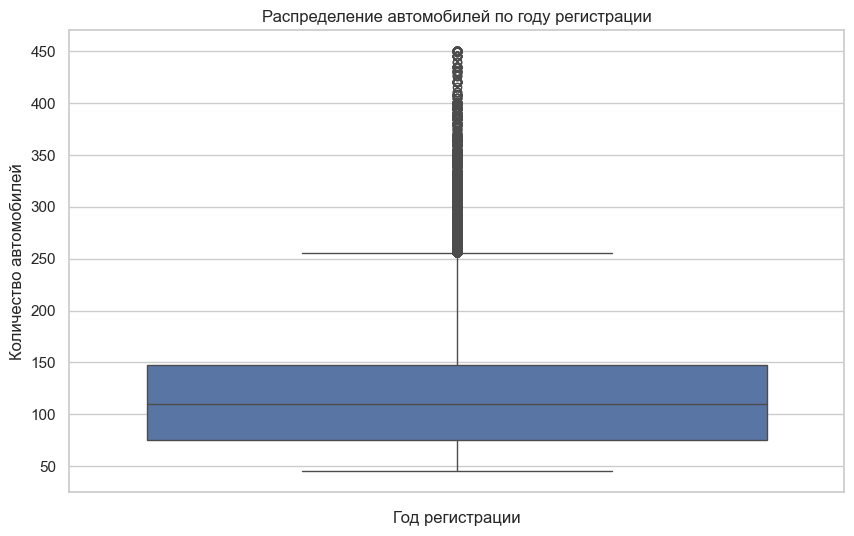

In [130]:
replace_outliers(data, 'power')
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data['power'])
plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('Год регистрации') 
plt.ylabel('Количество автомобилей') 
plt.xticks(rotation=45)
plt.show() 

In [131]:
dataframe_summary(data, 'data')

Общая информация по таблице: data
<class 'pandas.core.frame.DataFrame'>
Index: 319205 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              319205 non-null  int64 
 1   vehicle_type       319205 non-null  object
 2   registration_year  319205 non-null  int64 
 3   gearbox            319205 non-null  object
 4   power              319205 non-null  int64 
 5   model              319205 non-null  object
 6   kilometer          319205 non-null  int64 
 7   fuel_type          319205 non-null  object
 8   brand              319205 non-null  object
 9   repaired           319205 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.8+ MB

 Статистическое описание:


,count,mean,std,min,25%,50%,75%,max
price,"319,205.00","4,620.53","4,525.41",1.00,"1,200.00","2,950.00","6,600.00","20,000.00"
registration_year,"319,205.00","2,003.64",6.24,"1,985.00","1,999.00","2,003.00","2,008.00","2,019.00"
power,"319,205.00",118.96,51.93,45.00,75.00,110.00,147.00,450.00
kilometer,"319,205.00","129,039.33","36,481.35","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"



Случайные примеры:


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
225438,2850,wagon,1994,manual,99,3er,150000,petrol,bmw,no
284357,1400,small,2001,manual,50,polo,150000,petrol,volkswagen,no
46684,5800,sedan,2002,auto,192,3er,125000,petrol,bmw,no
297102,600,wagon,2000,manual,105,other,150000,petrol,fiat,no
212227,11950,wagon,2008,manual,200,octavia,100000,petrol,skoda,no



Количество строк и столбцов: (319205, 10)

Количество явных дубликатов: 56647



In [132]:
data.fuel_type	.unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Для оптимизации рабочих процессов компиьютера предлагаю уменьшить размерность данных где это возможно:
1) Можно перевести столбцы repaired и gearbox из разряда категориального в факторный, выразив как 1 и 0. 
2) Затем можно провести downсast всех числовых столбцов.

In [133]:
# Переименование столбца 'repaired' в 'is_repaired'
data.rename(columns={'repaired': 'is_repaired'}, inplace=True)

# Замена значений 'no' на 0 и 'yes' на 1 в столбце 'is_repaired'
data['is_repaired'] = data['is_repaired'].map({'no': 0, 'yes': 1})

In [134]:
# Переименование столбца 'gearbox' в 'is_automatic'
data.rename(columns={'gearbox': 'is_automatic'}, inplace=True)

# Замена значений 'manual' на 0 и 'auto' на 1 в столбце 'is_automatic'
data['is_automatic'] = data['is_automatic'].map({'manual': 0, 'auto': 1})

In [135]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Применяем downcast для каждого числового столбца
for col in numeric_cols:
    if data[col].dtype == 'int64':
        data[col] = pd.to_numeric(data[col], downcast='integer')  # Downcast целочисленных значений
    elif data[col].dtype == 'float64':
        data[col] = pd.to_numeric(data[col], downcast='float')

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 319205 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              319205 non-null  int16 
 1   vehicle_type       319205 non-null  object
 2   registration_year  319205 non-null  int16 
 3   is_automatic       319205 non-null  int8  
 4   power              319205 non-null  int16 
 5   model              319205 non-null  object
 6   kilometer          319205 non-null  int32 
 7   fuel_type          319205 non-null  object
 8   brand              319205 non-null  object
 9   is_repaired        319205 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 15.8+ MB


Удалось снизить потребление памяти на 10 MB

## Обучение моделей

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 319205 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              319205 non-null  int16 
 1   vehicle_type       319205 non-null  object
 2   registration_year  319205 non-null  int16 
 3   is_automatic       319205 non-null  int8  
 4   power              319205 non-null  int16 
 5   model              319205 non-null  object
 6   kilometer          319205 non-null  int32 
 7   fuel_type          319205 non-null  object
 8   brand              319205 non-null  object
 9   is_repaired        319205 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 15.8+ MB


In [137]:
X = data.drop('price', axis=1)  # Входные признаки (все кроме 'price')
y = data['price']  # Целевая переменная

# Разбиение на тренировочную и тестовую выборки с соотношением 80% к 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размеров полученных выборок для проверки
print(f"Тренировочная выборка: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Тестовая выборка: X_test: {X_test.shape}, y_test: {y_test.shape}")

Тренировочная выборка: X_train: (255364, 9), y_train: (255364,)
Тестовая выборка: X_test: (63841, 9), y_test: (63841,)


In [153]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Создание трансформера для числовых переменных
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Определение колонок для каждого типа кодирования
ohe_features = ['vehicle_type', 'fuel_type']
ordinal_features = ['brand', 'model']

# Создание трансформеров
ohe_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Создание препроцессора, который применяет трансформации к числовым и категориальным переменным
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ohe', ohe_transformer, ohe_features),
        ('ordinal', ordinal_transformer, ordinal_features)
    ])



In [ ]:
# Параметры для RandomizedSearchCV
param_dist = {
    'model__n_estimators': sp_randint(50, 150),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__num_leaves': sp_randint(20, 150),
    'model__max_depth': sp_randint(-1, 10),
}

In [166]:
# Параметры для RandomizedSearchCV
param_dist = {
    'model__learning_rate': uniform(0.1, 0.15),
    'model__num_leaves': sp_randint(100, 101)}


In [167]:
%%time

start_time = time.time()  # Начало замера времени

# Создание пайплайна с предобработчиком и моделью LightGBM
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # preprocessor был определен в предыдущих примерах
    ('model', lgb.LGBMRegressor(random_state=42))
])



# Создание и запуск RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=1,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=123,
    n_jobs=-2
)
random_search.fit(X_train, y_train)  # X_train, y_train должны быть определены заранее

end_time = time.time()  # Конец замера времени

# Вычисление и сохранение общего времени выполнения
total_time = end_time - start_time
print("Общее время выполнения: {:.2f} секунд".format(total_time))
print("Лучшее значение RMSE:",np.sqrt(-random_search.best_score_))


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 255364, number of used features: 17
[LightGBM] [Info] Start training from score 4624.261662
Общее время выполнения: 7.61 секунд
Лучшее значение RMSE: 3529.305336431089
CPU times: total: 3.14 s
Wall time: 7.61 s


In [164]:
model1_time = total_time
model1_params = random_search.best_params_

{'model__learning_rate': 0.14929383711957234,
 'model__max_depth': 1,
 'model__n_estimators': 142,
 'model__num_leaves': 118}

In [145]:
print("Общее время выполнения: {:.2f} секунд".format(total_time))
print("Лучшее значение RMSE:",random_search_ord.best_score_)


Общее время выполнения: 14.15 секунд
Лучшее значение RMSE: nan


In [170]:
# Создание конечного пайплайна, включающего предобработчик и модель линейной регрессии
linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Теперь можно использовать этот пайплайн для обучения и предсказаний
# Например:
linear_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index([], dtype='object')),
                                                 ('ohe',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type',
                                                   'fuel_type']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['brand', 'model'])])),
                ('regressor', LinearRegression())])

In [171]:
linear_model.best_score_

AttributeError: 'Pipeline' object has no attribute 'best_score_'

## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей